In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
today=dt.date.today()
today
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates

datetime.date(2018, 10, 4)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#see what's in table
data_table = session.query(Measurement).first()
data_table.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2446e5bb668>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [12]:
#go through data and find most recent date, then work backwards and collect data
#for the year before that date
from datetime import datetime
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
final_date = recent_date[0]
print(final_date)
type(final_date)
#d.strftime("%Y%m%d")
#final_date = dt.datetime.strptime(final_date, '%Y-%b-%d ')
#one_year_back = final_date - dt.timedelta(days=1*365) 
#one_year_back = final_date.replace(year = (final_date.year - 1))

#one_year_back = aYear_back.strftime("%Y-%m-%d")
#aYear_back

2017-08-23


str

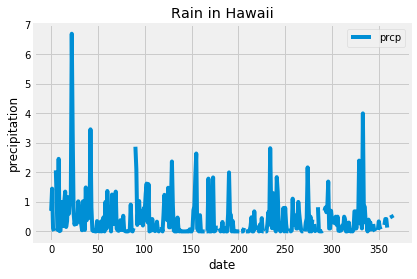

In [13]:
year_rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").group_by(Measurement.date).all()
#year_rain
year_rain_df = pd.DataFrame(year_rain)
#year_rain_df.head()
year_rain_df.plot()
plt.xlabel("date")
plt.ylabel("precipitation")
plt.title("Rain in Hawaii")
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data


In [15]:
rain_info = year_rain_df.describe()
rain_info

prcp
count  345.000000
mean     0.432087
std      0.704363
min      0.000000
25%      0.010000
50%      0.140000
75%      0.580000
max      6.700000

In [16]:
# How many stations are available in this dataset?
total_stations = session.query(Station.station).count()
total_stations

9

In [17]:
# What are the most active stations?
# List the stations and the counts in descending order.
most_active_station = session.query(Measurement.station,func.count(Measurement.station))
most_active_station = most_active_station.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()        
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [19]:
#most_active_station[0][0]


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.date, Measurement.tobs)
#.filter(Measurement.station==most_active_station[0]).order_by(Measurement.date).all()
tobs = tobs.filter(Measurement.date>="2016-08-23")
tobs.filter(Measurement.station==most_active_station[0]).order_by(Measurement.date).all()
#not sure what is happening here, come back and review!!!

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 1 - probably unsupported type. [SQL: 'SELECT measurement.date AS measurement_date, measurement.tobs AS measurement_tobs \nFROM measurement \nWHERE measurement.date >= ? AND measurement.station = ? ORDER BY measurement.date'] [parameters: ('2016-08-23', ('USC00519281', 2772))] (Background on this error at: http://sqlalche.me/e/rvf5)

In [21]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
class Temperature():
    '''
    Created a class to allow multiple returns from the function; without it, difficult to do so
    '''
    def __init__(self, maximum, minimum, average):
        self.maximum = maximum
        self.minimum = minimum
        self.average = average

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    maximum = session.query(func.max(Measurement.tobs)).filter(Measurement.date.between(start_date, end_date)).scalar()
    print(f"Maximum temp: {maximum}")
    minimum = session.query(func.min(Measurement.tobs)).filter(Measurement.date.between(start_date, end_date)).scalar()
    print(f"Minimum temp: {minimum}")
    average = session.query(func.round(func.avg(Measurement.tobs))).filter(Measurement.date.between(start_date, end_date)).scalar()
    print(f"Average temp: {average}")
    
    result = [{"Minimum":minimum},{"Maximum":maximum},{"Average":average}]
    result = Temperature(minimum, average, maximum)
    return result    

temperature = calc_temps('2017-03-01','2017-03-11')
temperature.maximum, temperature.minimum, temperature.average
    
#    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
#        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
#print(calc_temps('2012-02-28', '2012-03-05'))

Maximum temp: 82.0
Minimum temp: 62.0
Average temp: 71.0


(62.0, 71.0, 82.0)

In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
last_year_temperatures = calc_temps('2016-03-01','2016-03-11')
last_year_temperatures.minimum, last_year_temperatures.average, last_year_temperatures.maximum

Maximum temp: 78.0
Minimum temp: 62.0
Average temp: 70.0


(70.0, 78.0, 62.0)

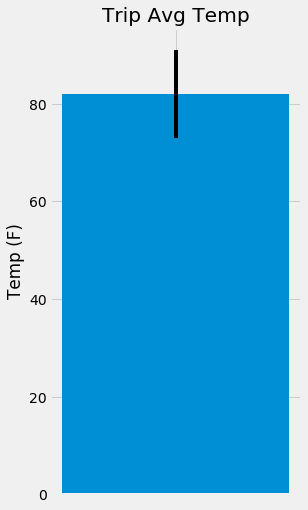

In [124]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize = (4,8))
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.bar(1, temperature.average, yerr = (temperature.maximum - temperature.minimum), tick_label = "")

# Save an image of the chart and print to screen
plt.savefig("TemperatureAnalysis_For_MarchBirthdayTrip.png")
plt.show()

In [127]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_at_all_stations = session.query(Measurement.station,func.sum(Measurement.prcp)).filter(Measurement.date.between('2016-03-01','2016-03-11')).group_by(Measurement.station).all()
rainfall_at_all_stations


[('USC00513117', 0.22999999999999998),
 ('USC00514830', 0.30000000000000004),
 ('USC00516128', 0.37),
 ('USC00517948', None),
 ('USC00519281', 0.38000000000000006),
 ('USC00519397', 0.19),
 ('USC00519523', 0.65)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


tmin       tavg  tmax
date                             
2018-01-01  62.0  69.153846  77.0
2018-01-02  60.0  69.396226  77.0
2018-01-03  62.0  68.909091  77.0
2018-01-04  58.0  70.000000  76.0
2018-01-05  56.0  67.964286  76.0

<IPython.core.display.Javascript object>


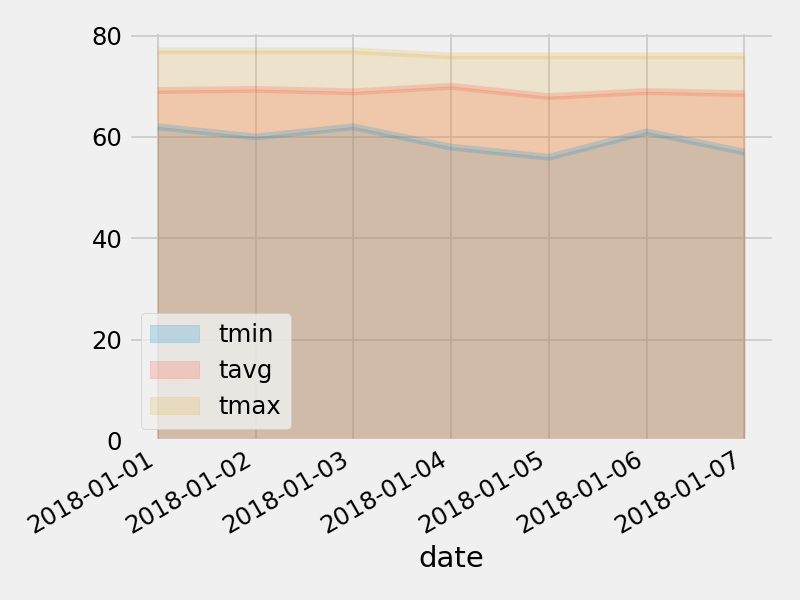

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
